# Residual Network with Keras

In theory, very deep networks can represent very complex functions; but in practice, they are hard to train. Residual Networks, introduced by [He et al.](https://arxiv.org/pdf/1512.03385.pdf), allow us to train much deeper networks than were previously practically feasible.

In this notebook, we will build a 50-layer ResNet model using Keras. 

The architecture of the model is the following:<br>ZERO PAD -> CONV -> BATCH NORM -> RELU -> MAX POOL -> CONV BLOCK -> ID BLOCK * 2 -> CONV BLOCK -> ID BLOCK * 3 -> CONV BLOCK -> ID BLOCK * 5 ->  CONV BLOCK -> ID BLOCK * 2 -> AVG POOL -> FLATTEN -> FULLY CONNECTED<br>in which ID BLOCK is the "identity block" and CONV BLOCK is the "convolutional block".

The model is then applied to "Sign Language" project as an illustration. 

## 1. Introduction

In recent years, neural networks have become deeper, with state-of-the-art networks going from just a few layers (e.g., AlexNet) to over a hundred layers.

The main benefit of a very deep network is that it can represent very complex functions. It can also learn features at many different levels of abstraction, from edges (at the lower layers) to very complex features (at the deeper layers). However, using a deeper network doesn't always help. A huge barrier to training them is vanishing gradients: very deep networks often have a gradient signal that goes to zero quickly, thus making gradient descent unbearably slow. More specifically, during gradient descent, as we backprop from the final layer back to the first layer, we are multiplying by the weight matrix on each step, and thus the gradient can decrease exponentially quickly to zero (or, in rare cases, grow exponentially quickly and "explode" to take very large values). 

During training, we might therefore see the magnitude (or norm) of the gradient for the earlier layers descrease to zero very rapidly as training proceeds: 

<img src="images/vanishing_grad.png" style="width:450px;height:220px;">

The speed of learning decreases very rapidly for the early layers as the network trains.

We can solve this problem by building a Residual Network.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import math
import h5py
from keras import layers
from keras.layers import Input, ZeroPadding2D, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D
from keras.layers import AveragePooling2D, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.models import Model
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
import keras.backend as K
# Sets the value of the image data format convention.
K.set_image_data_format('channels_last')
from keras.models import load_model
import pydot
from IPython.display import SVG
import matplotlib.pyplot as plt

Using TensorFlow backend.


## 2. Residual Network Construction

In ResNets, a "shortcut" or a "skip connection" allows the gradient to be directly backpropagated to earlier layers:  

<img src="images/skip_connection.png" style="width:650px;height:200px;">

The image on the left shows the "main path" through the network. The image on the right adds a shortcut to the main path. By stacking these ResNet blocks on top of each other, we can form a very deep network. 

We also see that having ResNet blocks with the shortcut also makes it very easy for one of the blocks to learn an identity function. This means that we can stack on additional ResNet blocks with little risk of harming training set performance. There is also some evidence that the ease of learning an identity function - even more than skip connections helping with vanishing gradients - accounts for ResNets' remarkable performance.

Two main types of blocks are used in a ResNet, depending mainly on whether the input/output dimensions are same or different. We are going to implement both of them. 

### 2.1 The identity block

The identity block is the standard block used in ResNets, and corresponds to the case where the input activation (say $a^{[l]}$) has the same dimension as the output activation (say $a^{[l+2]}$). To flesh out the different steps of what happens in a ResNet's identity block, here is an alternative diagram showing the individual steps:

<img src="images/idblock2.png" style="width:650px;height:150px;">

Skip connection "skips over" 2 layers.

The upper path is the "shortcut path." The lower path is the "main path." In this diagram, we have also made explicit the CONV2D and ReLU steps in each layer. To speed up training we have also added a BatchNorm step.

In this notebook, we'll actually implement a slightly more powerful version of this identity block, in which the skip connection "skips over" 3 hidden layers rather than 2 layers. It looks like this: 

<img src="images/idblock3.png" style="width:650px;height:150px;">

Here're the individual steps.

First component of main path: 
- The first CONV2D has $F_1$ filters of shape (1,1) and a stride of (1,1). Its padding is "valid" and its name should be `conv_name_base + '2a'`. Use 0 as the seed for the random initialization. 
- The first BatchNorm is normalizing the channels axis.  Its name should be `bn_name_base + '2a'`.
- Then apply the ReLU activation function. This has no name and no hyperparameters. 

Second component of main path:
- The second CONV2D has $F_2$ filters of shape $(f,f)$ and a stride of (1,1). Its padding is "same" and its name should be `conv_name_base + '2b'`. Use 0 as the seed for the random initialization. 
- The second BatchNorm is normalizing the channels axis.  Its name should be `bn_name_base + '2b'`.
- Then apply the ReLU activation function. This has no name and no hyperparameters. 

Third component of main path:
- The third CONV2D has $F_3$ filters of shape (1,1) and a stride of (1,1). Its padding is "valid" and its name should be `conv_name_base + '2c'`. Use 0 as the seed for the random initialization. 
- The third BatchNorm is normalizing the channels axis.  Its name should be `bn_name_base + '2c'`. Note that there is no ReLU activation function in this component. 

Final step: 
- The shortcut and the input are added together.
- Then apply the ReLU activation function. This has no name and no hyperparameters. 

**Note** that $F_3$ should be equal to the channel number of input x to match the dimension.

In [2]:
# implement the identity block

def identity_block(X, f, filters, stage, block):
    """
    Arguments:
    X: input tensor, with dimension (m, n_h_prev, n_w_prev, n_c_prev)
    f: integer, the shape of the middle CONV2D's filter in the main path
    filters: python list of integers, the number of filters in the CONV2D layers in the main path
    stage: integer, used to name the layers depending on their position in the network
    block: string/character, used to name the layers depending on their position within a stage
    
    Returns:
    X: output of the block, tensor with dimension (m, n_h, n_w, n_c)
    """
    
    # define the name basis
    conv_name_base = 'conv_stage' + str(stage) + '_block' + block + '_branch'
    bn_name_base = 'bn_stage' + str(stage) + '_block' + block + '_branch'
    
    # retrieve the number of filters in the main path
    F1, F2, F3 = filters
    
    # save the input for shortcut
    X_shortcut = X
    
    # first component in the main path
    # Glorot normal initializer, also called Xavier normal initializer.
    # It draws samples from a truncated normal distribution centered on 0 with  stddev = sqrt(2 / (fan_in + fan_out)) 
    # where fan_in is the number of input units in the weight tensor and  fan_out is the number of output units in 
    # the weight tensor.
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1, 1), padding = 'valid', name = conv_name_base + '2a', 
               kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # second component in the main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1, 1), padding = 'same', name = conv_name_base + '2b', 
               kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    
    # third component in the main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1, 1), padding = 'valid', name = conv_name_base + '2c', 
               kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
    
    # final step
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)
    
    return X

### 2.2 The Convolutional Block

The ResNet "convolutional block" is the other type of block. We can use this type of block when the input and output dimensions don't match up. The difference with the identity block is that there is a CONV2D layer in the shortcut path: 

<img src="images/convblock.png" style="width:650px;height:150px;">

The CONV2D layer in the shortcut path is used to resize the input $x$ to a different dimension, so that the dimensions match up in the final addition needed to add the shortcut value back to the main path. For example, to reduce the activation dimensions's height and width by a factor of 2, you can use a 1x1 convolution with a stride of 2. The CONV2D layer on the shortcut path does not use any non-linear activation function. Its main role is to just apply a (learned) linear function that reduces the dimension of the input, so that the dimensions match up for the later addition step. 

The details of the convolutional block are as follows. 

First component in main path:
- The first CONV2D has $F_1$ filters of shape (1,1) and a stride of (s,s). Its padding is "valid" and its name should be `conv_name_base + '2a'`. 
- The first BatchNorm is normalizing the channels axis.  Its name should be `bn_name_base + '2a'`.
- Then apply the ReLU activation function. This has no name and no hyperparameters. 

Second component in main path:
- The second CONV2D has $F_2$ filters of (f,f) and a stride of (1,1). Its padding is "same" and it's name should be `conv_name_base + '2b'`.
- The second BatchNorm is normalizing the channels axis.  Its name should be `bn_name_base + '2b'`.
- Then apply the ReLU activation function. This has no name and no hyperparameters. 

Third component in main path:
- The third CONV2D has $F_3$ filters of (1,1) and a stride of (1,1). Its padding is "valid" and it's name should be `conv_name_base + '2c'`.
- The third BatchNorm is normalizing the channels axis.  Its name should be `bn_name_base + '2c'`. Note that there is no ReLU activation function in this component. 

Shortcut path:
- The CONV2D has $F_3$ filters of shape (1,1) and a stride of (s,s). Its padding is "valid" and its name should be `conv_name_base + '1'`.
- The BatchNorm is normalizing the channels axis.  Its name should be `bn_name_base + '1'`. 

Final step: 
- The shortcut and the main path values are added together.
- Then apply the ReLU activation function. This has no name and no hyperparameters. 

In [3]:
# implement the convolutional block

def conv_block(X, f, filters, stage, block, s):
    """
    Arguments:
    X: input tensor, with dimension (m, n_h_prev, n_w_prev, n_c_prev)
    f: integer, the shape of the middle CONV2D's filter in the main path
    filters: python list of integers, the number of filters in the CONV2D layers in the main path
    stage: integer, used to name the layers depending on their position in the network
    block: string/character, used to name the layers depending on their position within a stage
    s: integer, the stride to be used
    
    Returns:
    X: output of the block, tensor with dimension (m, n_h, n_w, n_c)
    """
    
    # define the name basis
    conv_name_base = 'conv_stage' + str(stage) + '_block' + block + '_branch'
    bn_name_base = 'bn_stage' + str(stage) + '_block' + block + '_branch'
    
    # retrieve the number of filters in the main path
    F1, F2, F3 = filters
    
    # save the input for shortcur
    X_shortcut = X
    
    # first component in the main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (s, s), padding = 'valid', name = conv_name_base + '2a', 
               kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # second component in the main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1, 1), padding = 'same', name = conv_name_base + '2b', 
               kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    
    # third component in the main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1, 1), padding = 'valid', name = conv_name_base + '2c', 
               kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
    
    # shortcut path
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s, s), padding = 'valid', 
                        name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed = 0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)
    
    # final step
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)
    
    return X

## 3. ResNet Model (50 Layers)

ResNet50 is a powerful model for image classification when it is trained for an adequate number of iterations. 

We now have the necessary blocks to build a very deep ResNet. The following figure describes in detail the architecture of this neural network. "ID BLOCK" in the diagram stands for "Identity block," and "ID BLOCK x3" means we stack 3 identity blocks together.

<img src="images/resnet.png" style="width:850px;height:150px;">

The details of this ResNet-50 model are:
- Zero-padding pads the input with a pad of (3,3)
- Stage 1:
    - The 2D Convolution has 64 filters of shape (7,7) and uses a stride of (2,2). Its padding is "valid" and its name is "conv1".
    - BatchNorm is applied to the channels axis of the input. Its name is "bn1"
    - MaxPooling uses a (3,3) window and a (2,2) stride and its name is "max_pool".
- Stage 2:
    - The convolutional block uses three set of filters of size [64,64,256], "f" is 3, "s" is 1 and the block is "a".
    - The 2 identity blocks use three set of filters of size [64,64,256], "f" is 3 and the blocks are "b" and "c".
- Stage 3:
    - The convolutional block uses three set of filters of size [128,128,512], "f" is 3, "s" is 2 and the block is "a".
    - The 3 identity blocks use three set of filters of size [128,128,512], "f" is 3 and the blocks are "b", "c" and "d".
- Stage 4:
    - The convolutional block uses three set of filters of size [256, 256, 1024], "f" is 3, "s" is 2 and the block is "a".
    - The 5 identity blocks use three set of filters of size [256, 256, 1024], "f" is 3 and the blocks are "b", "c", "d", "e" and "f".
- Stage 5:
    - The convolutional block uses three set of filters of size [512, 512, 2048], "f" is 3, "s" is 2 and the block is "a".
    - The 2 identity blocks use three set of filters of size [512, 512, 2048], "f" is 3 and the blocks are "b" and "c".
- The 2D Average Pooling uses a window of shape (2,2) and its name is "avg_pool".
- The flatten doesn't have any hyperparameters or name.
- The Fully Connected (Dense) layer reduces its input to the number of classes using a softmax activation. Its name should be `'fc' + str(classes)`.

In [4]:
def RevNet50(input_shape, classes):
    """
    Implement the ResNet-50 model, with the following architecture:
    ZERO PAD -> CONV -> BATCH NORM -> RELU -> MAX POOL -> CONV BLOCK -> ID BLOCK * 2 -> CONV BLOCK -> ID BLOCK * 3 ->  
    CONV BLOCK -> ID BLOCK * 5 ->  CONV BLOCK -> ID BLOCK * 2 -> AVG POOL -> FLATTEN -> FULLY CONNECTED
    
    Argument:
    input_shape: the shape of the input image (nh, nw, nc), not including the batch size
    classes: integer, number of classes
    
    Returns:
    model: a Model() instance in Keras
    """
    
    X_input = Input(input_shape)
    
    # Zero-paddding
    X = ZeroPadding2D(padding = (3, 3))(X_input)
    
    # stage 1
    X = Conv2D(filters = 64, kernel_size = (7, 7), strides = (2, 2), padding = 'valid', name = 'conv1', 
               kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = 'bn1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(pool_size = (3, 3), strides = (2, 2), name = 'max_pool')(X)
    
    # stage 2
    X = conv_block(X, f = 3, filters = [64, 64, 256], stage = 2, block = 'a', s = 1)
    X = identity_block(X, f = 3, filters = [64, 64, 256], stage = 2, block = 'b')
    X = identity_block(X, f = 3, filters = [64, 64, 256], stage = 2, block = 'c')
    
    # stage 3
    X = conv_block(X, f = 3, filters = [128, 128, 512], stage = 3, block = 'a', s = 2)
    X = identity_block(X, f = 3, filters = [128, 128, 512], stage = 3, block = 'b')
    X = identity_block(X, f = 3, filters = [128, 128, 512], stage = 3, block = 'c')
    X = identity_block(X, f = 3, filters = [128, 128, 512], stage = 3, block = 'd')
    
    # stage 4
    X = conv_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block = 'a', s = 2)
    X = identity_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block = 'b')
    X = identity_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block = 'c')
    X = identity_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block = 'd')
    X = identity_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block = 'e')
    X = identity_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block = 'f')
    
    # stage 5
    X = conv_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block = 'a', s = 2)
    X = identity_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block = 'b')
    X = identity_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block = 'c')
    
    # Average pooling, flatten, and fully-connected layer
    X = AveragePooling2D(pool_size = (2, 2), name = 'avg_pool')(X)
    X = Flatten()(X)
    X = Dense(units = classes, activation = 'softmax', name = 'fc' + str(classes), 
              kernel_initializer = glorot_uniform(seed = 0))(X)
    
    # Create Model
    model = Model(inputs = X_input, outputs = X, name = 'ResNet50')
    
    return model

## 4. Example: Sign Language

One afternoon, we decided to teach our computers to decipher sign language. We spent a few hours taking pictures in front of a white wall and came up with the following dataset： 

- **Training set**: 1080 pictures (64 by 64 pixels) of signs representing numbers from 0 to 5 (180 pictures per number).
- **Test set**: 120 pictures (64 by 64 pixels) of signs representing numbers from 0 to 5 (20 pictures per number).

Here are examples for each number, and how we represent the labels. These are the original pictures, before we lowered the image resolutoion to 64 by 64 pixels.

<img src="images/hands.png" style="width:800px;height:350px;">

Our goal is to build an algorithm that would facilitate communications from a speech-impaired person to someone who doesn't understand sign language.

In [5]:
# load training and test data, and list of classes

def load_data():
    """
    Returns:
    train_x_orig: numpy array, original training set features 
    train_y_orig: numpy array, original training set labels 
    test_x_orig: numpy array, original test set features 
    test_y_orig: numpy array, original test set labels 
    classes: numpy array, list of classes  
    """
    # training set
    train_data = h5py.File('data/train_signs.h5', 'r')
    train_x_orig = np.array(train_data['train_set_x']) # training set features
    train_y_orig = np.array(train_data['train_set_y']) # training set labels
    # test set
    test_data = h5py.File('data/test_signs.h5', 'r')
    test_x_orig = np.array(test_data['test_set_x']) # test set features
    test_y_orig = np.array(test_data['test_set_y']) # test set labels
    # list of classes
    classes = np.array(test_data['list_classes'])
    # reshape the labels, make sure the dimension is (1, number of examples)
    train_y_orig = train_y_orig.reshape((1, train_y_orig.shape[0]))
    test_y_orig = test_y_orig.reshape((1, test_y_orig.shape[0]))
    
    return train_x_orig, train_y_orig, test_x_orig, test_y_orig, classes    

In [6]:
# load the data

train_x_orig, train_y_orig, test_x_orig, test_y_orig, classes = load_data()
print("Total number of training examples: " + str(train_x_orig.shape[0]))
print("Total number of test examples: " + str(test_x_orig.shape[0]))
print("Size of each image: " + str(train_x_orig[0].shape))
print("All classes: " + str(classes))
print("train_x_orig shape: " + str(train_x_orig.shape))
print("train_y_orig shape: " + str(train_y_orig.shape))
print("test_x_orig shape: " + str(test_x_orig.shape))
print("test_y_orig shape: " + str(test_y_orig.shape))

Total number of training examples: 1080
Total number of test examples: 120
Size of each image: (64, 64, 3)
All classes: [0 1 2 3 4 5]
train_x_orig shape: (1080, 64, 64, 3)
train_y_orig shape: (1, 1080)
test_x_orig shape: (120, 64, 64, 3)
test_y_orig shape: (1, 120)


In [7]:
# show some examples of the images in the training set

def example(indices, X, Y, classes):
    """
    Arguments:
    indices: list of the indices of X to be shown
    X: image fearues, with the shape of (number of examples, num_px, num_px, 3)
    Y: image classes, with the shape of (1, number of examples)
    classes: numpy array, list of classes
    """
    
    num = len(indices)
    columns = 5 # the number of columns to arrange the figures
    plt.figure(figsize = (20, 12))
    
    for i in range(num):
        plt.subplot(math.ceil(num / columns), columns, i + 1)
        plt.imshow(X[indices[i]])
        plt.axis('off')
        plt.title("Index = " + str(indices[i]) + ", class: " + str(classes[Y[0, indices[i]]]))

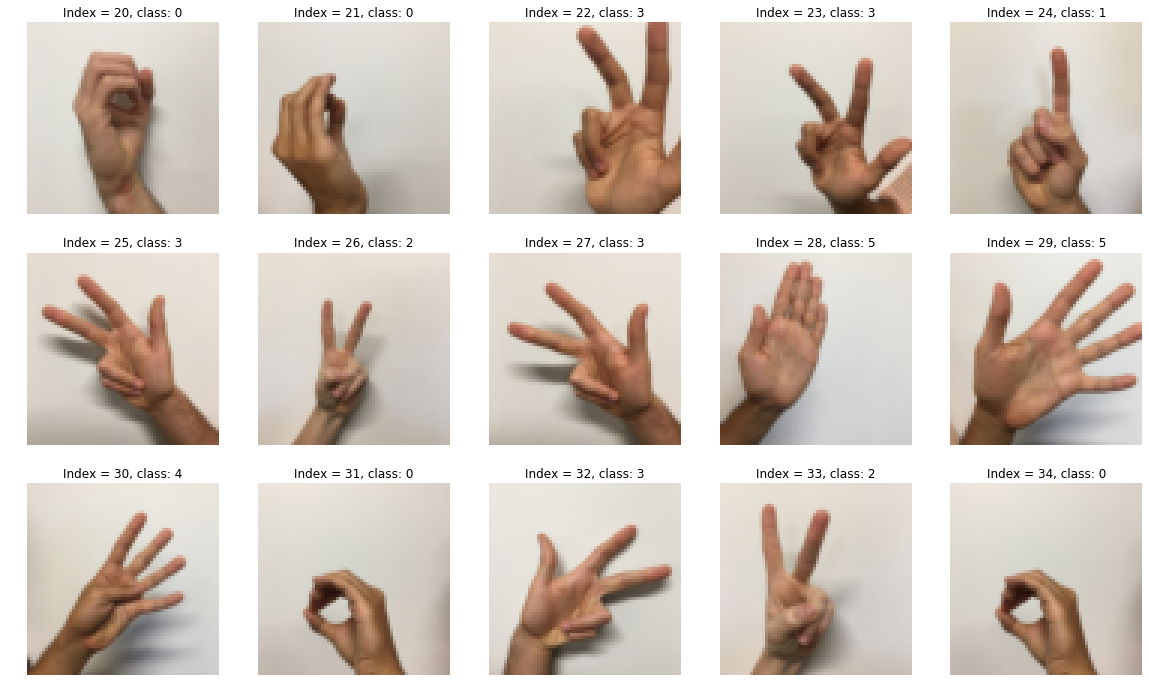

In [8]:
indices = [i for i in range(20, 35, 1)]
example(indices, train_x_orig, train_y_orig, classes)

## 5. Data Pre-Processing

In [9]:
# convert Y to one-hot vectors

def convert_to_one_hot(Y, C):
    """
    Argument:
    Y: labels, with the dimension of (1, number of examples)
    C: number of classes
    
    Returns:
    Y_converted: one-hot representation of Y, with the dimension of (C, number of examples)
    """
    # numpy.eye(): Return a 2-D array with ones on the diagonal and zeros elsewhere.
    # note that the ith column is exactly the one-hot representation of the ith class 
    Y_converted = np.eye(C)[:, Y.reshape(-1)]
    
    return Y_converted

In [10]:
# pre-processing the features

# standardize, so the values are between 0 and 1.
train_x = train_x_orig / 255
test_x = test_x_orig / 255

# convert labels to one-hot vectors
train_y = convert_to_one_hot(train_y_orig, len(classes)).T
test_y = convert_to_one_hot(test_y_orig, len(classes)).T


print("dimension of train_x: " + str(train_x.shape))
print("dimension of test_x: " + str(test_x.shape))
print("dimension of train_y: " + str(train_y.shape))
print("dimension of test_y: " + str(test_y.shape))

dimension of train_x: (1080, 64, 64, 3)
dimension of test_x: (120, 64, 64, 3)
dimension of train_y: (1080, 6)
dimension of test_y: (120, 6)


## 6. Model Training

In [14]:
# step 1: create the model

model = RevNet50(input_shape = (64, 64, 3), classes = 6)

In [15]:
# step 2: compile the model to configure the learning process

model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [16]:
# step 3: train the model

model.fit(x = train_x, y = train_y, batch_size = 32, epochs = 30)

Epoch 1/30
1080/1080 [==============================] - 95s 88ms/step - loss: 1.8602 - acc: 0.4537
Epoch 2/30
1080/1080 [==============================] - 71s 66ms/step - loss: 0.7543 - acc: 0.7370
Epoch 3/30
1080/1080 [==============================] - 70s 65ms/step - loss: 0.4755 - acc: 0.8435
Epoch 4/30
1080/1080 [==============================] - 71s 66ms/step - loss: 0.3320 - acc: 0.8787
Epoch 5/30
1080/1080 [==============================] - 74s 68ms/step - loss: 0.2857 - acc: 0.9213
Epoch 6/30
1080/1080 [==============================] - 78s 72ms/step - loss: 0.1175 - acc: 0.9648
Epoch 7/30
1080/1080 [==============================] - 73s 68ms/step - loss: 0.0795 - acc: 0.9750
Epoch 8/30
1080/1080 [==============================] - 73s 68ms/step - loss: 0.1401 - acc: 0.9556
Epoch 9/30
1080/1080 [==============================] - 72s 66ms/step - loss: 0.1163 - acc: 0.9667
Epoch 10/30
1080/1080 [==============================] - 73s 68ms/step - loss: 0.0799 - acc: 0.9741
Epoch 11/

In [17]:
# step 4: evaluate/test the model

preds = model.evaluate(x = test_x, y =test_y)
print("Loss: " + str(preds[0]))
print("Test Accuracy: " + str(preds[1]))

120/120 [==============================] - 7s 61ms/step
Loss: 0.11433246883874139
Test Accuracy: 0.9833333333333333


## 7. Save and Reload Model

We can use model.save(filepath) to save a Keras model into a single HDF5 file which will contain:

- the architecture of the model, allowing to re-create the model
- the weights of the model
- the training configuration (loss, optimizer)
- the state of the optimizer, allowing to resume training exactly where we left off.

We can then use keras.models.load_model(filepath) to reinstantiate our model. load_model will also take care of compiling the model using the saved training configuration (unless the model was never compiled in the first place).

Example:

```python
from keras.models import load_model

model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
model = load_model('my_model.h5')
```

In [18]:
# save the model

model.save('model/ResNet50_model.h5') 

In [19]:
# reload the model

model = load_model('model/ResNet50_model.h5')

In [20]:
model.fit(x = train_x, y = train_y, batch_size = 32, epochs = 1)

Epoch 1/1
1080/1080 [==============================] - 92s 85ms/step - loss: 2.2439e-04 - acc: 1.0000


## 8. Model Schematics

### 8.1 Model Summary

model.summary(): prints the details of your layers in a table with the sizes of its inputs/outputs

In [21]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 70, 70, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 32, 32, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

### 8.2 Model Layout 

keras.utils.plot_model(): plots our graph in a nice layout. We can even save it as ".png" using SVG() if we'd like to share it on social media.

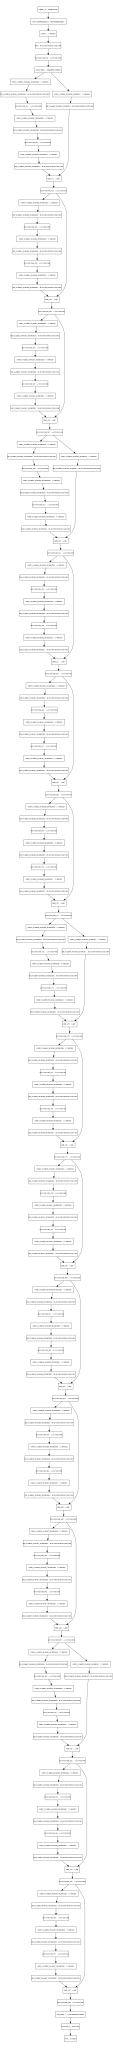

In [22]:
plot_model(model, to_file='images/ResNet50.png', show_shapes = True)
SVG(model_to_dot(model).create(prog='dot', format='svg'))

## References 

This notebook presents the ResNet algorithm due to He et al. (2015). The implementation here also took significant inspiration and follows the structure given in the github repository of Francois Chollet: 

- Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun - [Deep Residual Learning for Image Recognition (2015)](https://arxiv.org/abs/1512.03385)
- Francois Chollet's github repository: https://github.com/fchollet/deep-learning-models/blob/master/resnet50.py
